In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model, layers
from keras.layers import Conv1D, MaxPooling1D, Conv1DTranspose, UpSampling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-03-12 01:48:44.642677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741736924.653154 3210103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741736924.656297 3210103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 01:48:44.668381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [3]:
batch_size = 32
epochs = 1000
window_size = 16

In [4]:
def windowed_dataset(data, window_size, batch_size, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shuffle=False)
test_set = windowed_dataset(train, window_size, batch_size, shuffle=False)

I0000 00:00:1741736926.234435 3210103 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21985 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


In [7]:
def build_model(lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(window_size, 1)),
        Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1DTranspose(filters=128, kernel_size=3, padding='same', activation='relu'),
        UpSampling1D(size=2),
        Conv1DTranspose(filters=64, kernel_size=3, padding='same', activation='relu'),
        UpSampling1D(size=2),
        Conv1DTranspose(filters=32, kernel_size=3, padding='same', activation='relu'),
        UpSampling1D(size=2),
        Conv1DTranspose(filters=16, kernel_size=3, padding='same', activation='relu'),
        UpSampling1D(size=2),
        Conv1DTranspose(filters=1, kernel_size=3, padding='same', activation='relu')
    ])

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=3000,
        decay_rate=0.9,
        staircase=True
    )

    model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss='mse', metrics=['mae'])
    return model

In [8]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1, 128)         │        49,280 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 2, 64)          │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 4, 32)          │         6,176 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 8, 16)          │         1,552 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 16, 1)          │            49 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,241 (446.25 KB)

 Trainable params: 114,241 (446.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

Epoch 1/1000


I0000 00:00:1741736928.178853 3210405 service.cc:148] XLA service 0x7fb918005920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741736928.178873 3210405 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-12 01:48:48.216477: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741736928.377887 3210405 cuda_dnn.cc:529] Loaded cuDNN version 90300


     87/Unknown 3s 1ms/step - loss: 139.6548 - mae: 5.1001

I0000 00:00:1741736929.511266 3210405 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    108/Unknown 4s 12ms/step - loss: 131.2578 - mae: 4.8003

2025-03-12 01:48:50.776221: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-12 01:48:50.776250: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-12 01:48:50.776270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 130.8677 - mae: 4.7868 - val_loss: 86.9131 - val_mae: 3.1070
Epoch 2/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.0296 - mae: 5.3372 

2025-03-12 01:48:51.494844: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:48:51.494866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:51.494875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:51.637520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.1316 - mae: 5.0250 - val_loss: 86.9975 - val_mae: 3.0809
Epoch 3/1000
 93/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.3576 - mae: 5.2349 

2025-03-12 01:48:51.728888: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:48:51.728909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.4377 - mae: 5.0312 - val_loss: 87.6491 - val_mae: 2.9838
Epoch 4/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134.5425 - mae: 5.0829 

2025-03-12 01:48:51.959008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:51.959025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127.1328 - mae: 4.8420 - val_loss: 87.9398 - val_mae: 2.9501
Epoch 5/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137.4263 - mae: 4.6847 

2025-03-12 01:48:52.189545: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:48:52.189568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:52.331006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128.1177 - mae: 4.3772 - val_loss: 85.3037 - val_mae: 3.3660
Epoch 6/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131.8545 - mae: 5.3363 

2025-03-12 01:48:52.423410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:52.423427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:52.559882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125.0468 - mae: 5.0967 - val_loss: 87.2482 - val_mae: 3.0354
Epoch 7/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.3577 - mae: 4.7257 

2025-03-12 01:48:52.654406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:52.654422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:52.794375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.9742 - mae: 4.4559 - val_loss: 84.6718 - val_mae: 3.5188
Epoch 8/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133.1361 - mae: 5.4655 

2025-03-12 01:48:52.888868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124.0361 - mae: 5.1425 - val_loss: 85.8792 - val_mae: 3.2242
Epoch 9/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.4067 - mae: 4.9220 

2025-03-12 01:48:53.132630: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:48:53.132651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:53.132660: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:53.270478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124.6162 - mae: 4.6913 - val_loss: 84.0152 - val_mae: 3.5624
Epoch 10/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128.4941 - mae: 5.4038 

2025-03-12 01:48:53.374306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:53.374327: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:53.511080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.4903 - mae: 5.1805 - val_loss: 84.5628 - val_mae: 3.4493
Epoch 11/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130.3318 - mae: 5.2001 

2025-03-12 01:48:53.606460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:53.606477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:53.747623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.0556 - mae: 4.9689 - val_loss: 82.9702 - val_mae: 3.7807
Epoch 12/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127.0666 - mae: 5.6289 

2025-03-12 01:48:53.844622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:53.844642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.2351 - mae: 5.3876 - val_loss: 83.2537 - val_mae: 3.7138
Epoch 13/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127.1252 - mae: 5.5077 

2025-03-12 01:48:54.083887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:54.083909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.5682 - mae: 5.2909 - val_loss: 82.6714 - val_mae: 3.8390
Epoch 14/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125.9960 - mae: 5.6246 

2025-03-12 01:48:54.320307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:54.320326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.5761 - mae: 5.4049 - val_loss: 82.4976 - val_mae: 3.8635
Epoch 15/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125.9893 - mae: 5.6544 

2025-03-12 01:48:54.559553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:54.559573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:54.701144: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.2383 - mae: 5.4257 - val_loss: 82.2495 - val_mae: 3.8913
Epoch 16/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124.5535 - mae: 5.6470 

2025-03-12 01:48:54.793721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:54.793742: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:54.931319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:54.931337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.8690 - mae: 5.4484 - val_loss: 82.0914 - val_mae: 3.8944
Epoch 17/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125.6978 - mae: 5.6896 

2025-03-12 01:48:55.025804: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:48:55.025826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:55.169109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.6526 - mae: 5.4491 - val_loss: 81.9359 - val_mae: 3.8993
Epoch 18/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124.7251 - mae: 5.6684 

2025-03-12 01:48:55.263486: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:55.263506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.4029 - mae: 5.4476 - val_loss: 81.7433 - val_mae: 3.8846
Epoch 19/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125.1723 - mae: 5.6740 

2025-03-12 01:48:55.504314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:55.504335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:55.646540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:55.646560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.1763 - mae: 5.4364 - val_loss: 81.6668 - val_mae: 3.8808
Epoch 20/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124.3477 - mae: 5.6433 

2025-03-12 01:48:55.743440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:55.743458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:55.882668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.0478 - mae: 5.4226 - val_loss: 81.5700 - val_mae: 3.8614
Epoch 21/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124.9421 - mae: 5.6233 

2025-03-12 01:48:55.977445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:56.119255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.9359 - mae: 5.3810 - val_loss: 81.3287 - val_mae: 3.8643
Epoch 22/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123.3306 - mae: 5.5993 

2025-03-12 01:48:56.213516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:56.354081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.4561 - mae: 5.3826 - val_loss: 80.9153 - val_mae: 3.9668
Epoch 23/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122.1501 - mae: 5.6210 

2025-03-12 01:48:56.450154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:56.586213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.9130 - mae: 5.4190 - val_loss: 80.8554 - val_mae: 3.8977
Epoch 24/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122.9136 - mae: 5.6588 

2025-03-12 01:48:56.686998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:56.687018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:56.828928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.4051 - mae: 5.4300 - val_loss: 80.6153 - val_mae: 3.8766
Epoch 25/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123.3679 - mae: 5.5946 

2025-03-12 01:48:56.924316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:57.069171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.1331 - mae: 5.3408 - val_loss: 79.6648 - val_mae: 3.9863
Epoch 26/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.5051 - mae: 5.5849 

2025-03-12 01:48:57.163610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:57.163630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:57.300832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.0807 - mae: 5.3832 - val_loss: 79.9233 - val_mae: 3.9536
Epoch 27/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.7797 - mae: 5.5195 

2025-03-12 01:48:57.396972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:57.396988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:57.534445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.2723 - mae: 5.3220 - val_loss: 78.9507 - val_mae: 4.0044
Epoch 28/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119.8216 - mae: 5.5704 

2025-03-12 01:48:57.626105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:57.626123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.8043 - mae: 5.3416 - val_loss: 78.6340 - val_mae: 3.9908
Epoch 29/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119.2889 - mae: 5.4392 

2025-03-12 01:48:57.865194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:57.865212: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.7469 - mae: 5.2158 - val_loss: 80.9193 - val_mae: 3.9319
Epoch 30/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121.7693 - mae: 5.5618 

2025-03-12 01:48:58.096622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:58.234142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.0091 - mae: 5.3660 - val_loss: 79.8635 - val_mae: 3.9129
Epoch 31/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.0584 - mae: 5.5294 

2025-03-12 01:48:58.327988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:58.328007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.6745 - mae: 5.3410 - val_loss: 79.5894 - val_mae: 3.8815
Epoch 32/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.1062 - mae: 5.4963 

2025-03-12 01:48:58.558142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:58.558165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:58.696956: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.0446 - mae: 5.2775 - val_loss: 79.8870 - val_mae: 3.8219
Epoch 33/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119.4970 - mae: 5.4422 

2025-03-12 01:48:58.792667: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:48:58.792685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:58.792692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:58.932335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:58.932355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.7256 - mae: 5.2272 - val_loss: 78.6408 - val_mae: 3.9577
Epoch 34/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118.2474 - mae: 5.5028 

2025-03-12 01:48:59.033498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:59.173186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.5955 - mae: 5.2900 - val_loss: 77.7565 - val_mae: 3.9416
Epoch 35/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118.3047 - mae: 5.3887 

2025-03-12 01:48:59.275043: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:59.416498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.5372 - mae: 5.1556 - val_loss: 80.1755 - val_mae: 3.9060
Epoch 36/1000
 83/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122.0527 - mae: 5.6254 

2025-03-12 01:48:59.512471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:59.512491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:48:59.657806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.6795 - mae: 5.3788 - val_loss: 79.0950 - val_mae: 3.8524
Epoch 37/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118.4425 - mae: 5.4015 

2025-03-12 01:48:59.751511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:59.886820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.6572 - mae: 5.2279 - val_loss: 77.8004 - val_mae: 3.8978
Epoch 38/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.4421 - mae: 5.3764 

2025-03-12 01:48:59.981360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:48:59.981375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.4892 - mae: 5.1873 - val_loss: 77.0607 - val_mae: 3.9802
Epoch 39/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.2400 - mae: 5.4394 

2025-03-12 01:49:00.212438: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:00.212460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:00.353843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.2456 - mae: 5.1969 - val_loss: 79.8463 - val_mae: 3.8728
Epoch 40/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119.8756 - mae: 5.5683 

2025-03-12 01:49:00.446505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:00.594475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.5852 - mae: 5.3486 - val_loss: 78.5490 - val_mae: 3.8226
Epoch 41/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118.3475 - mae: 5.4137 

2025-03-12 01:49:00.687521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:00.827640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.6278 - mae: 5.2115 - val_loss: 76.9129 - val_mae: 3.8851
Epoch 42/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.6765 - mae: 5.3209 

2025-03-12 01:49:00.919801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:01.058282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.1932 - mae: 5.1063 - val_loss: 76.9182 - val_mae: 3.9031
Epoch 43/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.1253 - mae: 5.4941 

2025-03-12 01:49:01.154274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:01.154294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:01.299793: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109.2967 - mae: 5.2379 - val_loss: 76.0889 - val_mae: 3.9076
Epoch 44/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.5615 - mae: 5.3430 

2025-03-12 01:49:01.395624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:01.395641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109.5379 - mae: 5.0969 - val_loss: 77.9014 - val_mae: 3.8437
Epoch 45/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.7086 - mae: 5.5040 

2025-03-12 01:49:01.630262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:01.630285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.4592 - mae: 5.3073 - val_loss: 76.0522 - val_mae: 3.9190
Epoch 46/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115.8175 - mae: 5.3769 

2025-03-12 01:49:01.869971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:01.869990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:02.011084: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108.6983 - mae: 5.1322 - val_loss: 75.4941 - val_mae: 3.9677
Epoch 47/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.7284 - mae: 5.3996 

2025-03-12 01:49:02.107532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:02.107552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.6364 - mae: 5.1866 - val_loss: 76.7340 - val_mae: 3.7417
Epoch 48/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.9835 - mae: 5.3955 

2025-03-12 01:49:02.340652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:02.340669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:02.477721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.5080 - mae: 5.1776 - val_loss: 75.5354 - val_mae: 3.8476
Epoch 49/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.6146 - mae: 5.4535 

2025-03-12 01:49:02.573022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:02.573043: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.5445 - mae: 5.2084 - val_loss: 75.1098 - val_mae: 3.8102
Epoch 50/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.7873 - mae: 5.4265 

2025-03-12 01:49:02.807989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:02.808010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.4044 - mae: 5.2055 - val_loss: 75.7619 - val_mae: 3.8180
Epoch 51/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.6736 - mae: 5.4189 

2025-03-12 01:49:03.040026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.3005 - mae: 5.1676 - val_loss: 75.5871 - val_mae: 3.8442
Epoch 52/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115.2269 - mae: 5.4328 

2025-03-12 01:49:03.283815: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:03.283835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:03.425004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.7012 - mae: 5.1743 - val_loss: 74.8984 - val_mae: 3.8150
Epoch 53/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.1029 - mae: 5.3598 

2025-03-12 01:49:03.518307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:03.658089: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.3351 - mae: 5.1220 - val_loss: 74.5758 - val_mae: 3.9018
Epoch 54/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.3832 - mae: 5.3995 

2025-03-12 01:49:03.755526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:03.896803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.7492 - mae: 5.1531 - val_loss: 75.5601 - val_mae: 3.8345
Epoch 55/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.6990 - mae: 5.4479 

2025-03-12 01:49:03.990476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:04.133467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.8092 - mae: 5.1695 - val_loss: 74.4769 - val_mae: 3.5294
Epoch 56/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.9192 - mae: 5.2644 

2025-03-12 01:49:04.224996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:04.225011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:04.360437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.8221 - mae: 5.0546 - val_loss: 75.8088 - val_mae: 3.6550
Epoch 57/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.2295 - mae: 5.3058 

2025-03-12 01:49:04.460031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:04.595158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.5305 - mae: 5.1104 - val_loss: 74.2864 - val_mae: 3.6981
Epoch 58/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.3955 - mae: 5.2164 

2025-03-12 01:49:04.687899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:04.687916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:04.824706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.0899 - mae: 4.9995 - val_loss: 73.4279 - val_mae: 3.6467
Epoch 59/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.3657 - mae: 5.2152 

2025-03-12 01:49:04.918289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:04.918308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:05.056402: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.8208 - mae: 4.9850 - val_loss: 73.7972 - val_mae: 3.5845
Epoch 60/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.6414 - mae: 5.2631 

2025-03-12 01:49:05.149421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:05.149441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.6842 - mae: 4.9874 - val_loss: 73.2086 - val_mae: 3.5791
Epoch 61/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.2308 - mae: 5.2311 

2025-03-12 01:49:05.387180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:05.387199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:05.530123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.3270 - mae: 4.9563 - val_loss: 73.6761 - val_mae: 3.6215
Epoch 62/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110.2581 - mae: 5.1976 

2025-03-12 01:49:05.624909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:05.770023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.8390 - mae: 4.9749 - val_loss: 73.9987 - val_mae: 3.6480
Epoch 63/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.6904 - mae: 5.2431 

2025-03-12 01:49:05.864110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:05.864130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:06.005452: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104.4685 - mae: 4.9921 - val_loss: 71.3113 - val_mae: 3.6500
Epoch 64/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110.5360 - mae: 5.2045 

2025-03-12 01:49:06.103034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:06.103052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:06.243274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.8381 - mae: 4.9678 - val_loss: 73.4739 - val_mae: 3.5771
Epoch 65/1000
 83/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.6657 - mae: 5.2760 

2025-03-12 01:49:06.340860: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:49:06.340876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:06.340885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:06.485219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.5187 - mae: 4.9951 - val_loss: 72.2266 - val_mae: 3.6622
Epoch 66/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.1111 - mae: 5.1580 

2025-03-12 01:49:06.581039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:06.581061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:06.718759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102.9008 - mae: 4.9418 - val_loss: 71.6200 - val_mae: 3.6557
Epoch 67/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107.4289 - mae: 5.1592 

2025-03-12 01:49:06.813678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:06.949791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101.8051 - mae: 4.9640 - val_loss: 70.2052 - val_mae: 3.5989
Epoch 68/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108.4443 - mae: 5.2131 

2025-03-12 01:49:07.047763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:07.047783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:07.186442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102.0254 - mae: 4.9845 - val_loss: 71.1496 - val_mae: 3.5429
Epoch 69/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.2940 - mae: 5.2068 

2025-03-12 01:49:07.279398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:07.279416: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:07.415604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.4109 - mae: 5.0093 - val_loss: 71.4712 - val_mae: 3.6081
Epoch 70/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107.8626 - mae: 5.1520 

2025-03-12 01:49:07.512706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:07.512725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101.3132 - mae: 4.9232 - val_loss: 69.1106 - val_mae: 3.5231
Epoch 71/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107.0790 - mae: 5.1145 

2025-03-12 01:49:07.744024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:07.886399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.0745 - mae: 4.8715 - val_loss: 71.9939 - val_mae: 3.5152
Epoch 72/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.8934 - mae: 5.0987 

2025-03-12 01:49:07.981154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:08.118232: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.8411 - mae: 4.8834 - val_loss: 74.7868 - val_mae: 3.6454
Epoch 73/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.2272 - mae: 5.2531 

2025-03-12 01:49:08.214047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:08.214064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:08.366101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.0535 - mae: 4.9718 - val_loss: 68.6871 - val_mae: 3.4293
Epoch 74/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108.9411 - mae: 5.2151 

2025-03-12 01:49:08.467949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:08.467972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101.7040 - mae: 4.9498 - val_loss: 69.2977 - val_mae: 3.6096
Epoch 75/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.1739 - mae: 5.1065 

2025-03-12 01:49:08.711488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:08.711511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:08.846545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.5685 - mae: 4.9085 - val_loss: 70.3263 - val_mae: 3.5264
Epoch 76/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.8541 - mae: 5.0859 

2025-03-12 01:49:08.940727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:08.940745: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.6280 - mae: 4.8776 - val_loss: 67.3031 - val_mae: 3.4775
Epoch 77/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103.4895 - mae: 5.0318 

2025-03-12 01:49:09.170193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:09.170215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:09.308134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.1593 - mae: 4.8154 - val_loss: 67.9068 - val_mae: 3.4721
Epoch 78/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102.4726 - mae: 5.0360 

2025-03-12 01:49:09.403052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96.0356 - mae: 4.8101 - val_loss: 67.6226 - val_mae: 3.5212
Epoch 79/1000
 83/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.3661 - mae: 5.1075 

2025-03-12 01:49:09.644116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96.1077 - mae: 4.8098 - val_loss: 65.5687 - val_mae: 3.4762
Epoch 80/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101.1436 - mae: 5.0121 

2025-03-12 01:49:09.884101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:10.025667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94.4663 - mae: 4.7797 - val_loss: 67.2423 - val_mae: 3.4076
Epoch 81/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100.1168 - mae: 4.9370 

2025-03-12 01:49:10.120699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:10.120717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:10.257573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94.1322 - mae: 4.7294 - val_loss: 66.8895 - val_mae: 3.4289
Epoch 82/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102.2177 - mae: 5.0150 

2025-03-12 01:49:10.352299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.6326 - mae: 4.7827 - val_loss: 67.7778 - val_mae: 3.4932
Epoch 83/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101.2120 - mae: 5.0066 

2025-03-12 01:49:10.584067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:10.584088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:10.721617: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.1439 - mae: 4.7920 - val_loss: 65.3648 - val_mae: 3.4379
Epoch 84/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99.5783 - mae: 4.9359  

2025-03-12 01:49:10.814377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93.4967 - mae: 4.7231 - val_loss: 62.3620 - val_mae: 3.4226
Epoch 85/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.3799 - mae: 4.9026  

2025-03-12 01:49:11.056167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:11.056184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:11.193079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91.4193 - mae: 4.6871 - val_loss: 64.1501 - val_mae: 3.3952
Epoch 86/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 98.2783 - mae: 4.9321  

2025-03-12 01:49:11.285943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:11.285961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:11.429610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.5268 - mae: 4.6520 - val_loss: 62.5927 - val_mae: 3.4129
Epoch 87/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.5752 - mae: 4.9060  

2025-03-12 01:49:11.524343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:11.666145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.6591 - mae: 4.6598 - val_loss: 61.9355 - val_mae: 3.3524
Epoch 88/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96.9960 - mae: 4.8735  

2025-03-12 01:49:11.760542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:11.760566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:11.901764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.7595 - mae: 4.6104 - val_loss: 62.4250 - val_mae: 3.3806
Epoch 89/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95.4964 - mae: 4.8694  

2025-03-12 01:49:11.994368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:11.994384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.1991 - mae: 4.6418 - val_loss: 60.6119 - val_mae: 3.3907
Epoch 90/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95.2016 - mae: 4.8381  

2025-03-12 01:49:12.234352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.2937 - mae: 4.6265 - val_loss: 61.0260 - val_mae: 3.3258
Epoch 91/1000
 82/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.4327 - mae: 4.8639  

2025-03-12 01:49:12.465963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:12.465985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:12.612022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.1952 - mae: 4.5714 - val_loss: 59.5965 - val_mae: 3.3519
Epoch 92/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93.6491 - mae: 4.8145  

2025-03-12 01:49:12.704917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:12.704936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:12.842664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.1360 - mae: 4.6085 - val_loss: 62.1846 - val_mae: 3.3812
Epoch 93/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94.0169 - mae: 4.8130  

2025-03-12 01:49:12.937457: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:12.937473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:13.073914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.0835 - mae: 4.5992 - val_loss: 58.3359 - val_mae: 3.3416
Epoch 94/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91.9966 - mae: 4.7432  

2025-03-12 01:49:13.167008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:13.167028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:13.301842: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.6780 - mae: 4.5512 - val_loss: 57.1093 - val_mae: 3.3357
Epoch 95/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92.8385 - mae: 4.8020  

2025-03-12 01:49:13.393324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.0253 - mae: 4.5452 - val_loss: 56.9887 - val_mae: 3.3019
Epoch 96/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92.2654 - mae: 4.7709  

2025-03-12 01:49:13.632451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:13.772105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.2004 - mae: 4.5443 - val_loss: 60.1586 - val_mae: 3.3728
Epoch 97/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93.5439 - mae: 4.7774  

2025-03-12 01:49:13.869035: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.5314 - mae: 4.5610 - val_loss: 57.3895 - val_mae: 3.3488
Epoch 98/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93.0326 - mae: 4.7877  

2025-03-12 01:49:14.100957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:14.100982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.0901 - mae: 4.5263 - val_loss: 56.2937 - val_mae: 3.3728
Epoch 99/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90.9585 - mae: 4.7826  

2025-03-12 01:49:14.337017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:14.337039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:14.478226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.2420 - mae: 4.5160 - val_loss: 55.3273 - val_mae: 3.3132
Epoch 100/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89.5462 - mae: 4.7326  

2025-03-12 01:49:14.573170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:14.710174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.5369 - mae: 4.4989 - val_loss: 59.3372 - val_mae: 3.3111
Epoch 101/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89.1671 - mae: 4.6877  

2025-03-12 01:49:14.811431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:14.948916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.3477 - mae: 4.4654 - val_loss: 53.9871 - val_mae: 3.2909
Epoch 102/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89.2233 - mae: 4.7242  

2025-03-12 01:49:15.040477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:15.040495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:15.183307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.1905 - mae: 4.4511 - val_loss: 53.0062 - val_mae: 3.2655
Epoch 103/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87.4815 - mae: 4.6535  

2025-03-12 01:49:15.275854: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81.3676 - mae: 4.4149 - val_loss: 52.1396 - val_mae: 3.2192
Epoch 104/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.6617 - mae: 4.6026  

2025-03-12 01:49:15.508671: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:15.508690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.0344 - mae: 4.3822 - val_loss: 53.9800 - val_mae: 3.1640
Epoch 105/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86.7485 - mae: 4.6385  

2025-03-12 01:49:15.739033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:15.739057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81.2081 - mae: 4.4252 - val_loss: 51.7904 - val_mae: 3.2229
Epoch 106/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.8716 - mae: 4.6357  

2025-03-12 01:49:15.968762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:16.116329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79.6689 - mae: 4.3950 - val_loss: 53.7097 - val_mae: 3.2945
Epoch 107/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87.1287 - mae: 4.6791  

2025-03-12 01:49:16.209161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:16.209182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:16.346976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81.3822 - mae: 4.4506 - val_loss: 52.6230 - val_mae: 3.2061
Epoch 108/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86.8747 - mae: 4.6019  

2025-03-12 01:49:16.444068: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:16.583184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.5738 - mae: 4.3559 - val_loss: 50.9805 - val_mae: 3.2679
Epoch 109/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.7493 - mae: 4.6659  

2025-03-12 01:49:16.676279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:16.819306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:16.819326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.8723 - mae: 4.3831 - val_loss: 53.0178 - val_mae: 3.2022
Epoch 110/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86.0613 - mae: 4.6061  

2025-03-12 01:49:16.914996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:16.915011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:17.056737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79.3512 - mae: 4.3402 - val_loss: 50.5039 - val_mae: 3.2145
Epoch 111/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84.4183 - mae: 4.5822  

2025-03-12 01:49:17.147207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:17.284825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.6941 - mae: 4.3535 - val_loss: 49.9287 - val_mae: 3.1497
Epoch 112/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84.8579 - mae: 4.5819  

2025-03-12 01:49:17.387502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:17.387521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:17.530230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.3673 - mae: 4.3258 - val_loss: 49.9592 - val_mae: 3.1653
Epoch 113/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.9971 - mae: 4.5536 

2025-03-12 01:49:17.629412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76.4939 - mae: 4.2889 - val_loss: 49.0701 - val_mae: 3.1607
Epoch 114/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.2752 - mae: 4.5290 

2025-03-12 01:49:17.864496: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:17.864516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:18.004412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.6731 - mae: 4.2609 - val_loss: 47.0558 - val_mae: 3.1182
Epoch 115/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81.6659 - mae: 4.5230 

2025-03-12 01:49:18.101399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:18.101418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:18.243748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.9193 - mae: 4.2418 - val_loss: 48.8702 - val_mae: 3.1610
Epoch 116/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81.5788 - mae: 4.4957 

2025-03-12 01:49:18.336659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:18.336679: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:18.476521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.6906 - mae: 4.2569 - val_loss: 47.2464 - val_mae: 3.0672
Epoch 117/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81.2402 - mae: 4.4732 

2025-03-12 01:49:18.573395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:18.573412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.1694 - mae: 4.2330 - val_loss: 47.6472 - val_mae: 3.1087
Epoch 118/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80.5670 - mae: 4.4412 

2025-03-12 01:49:18.808073: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:18.947877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.1377 - mae: 4.2233 - val_loss: 46.3252 - val_mae: 3.1142
Epoch 119/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78.4237 - mae: 4.4088 

2025-03-12 01:49:19.042443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:19.042463: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:19.178692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.9393 - mae: 4.1805 - val_loss: 45.5366 - val_mae: 3.0330
Epoch 120/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78.0099 - mae: 4.3733 

2025-03-12 01:49:19.273473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:19.273491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:19.413355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.9008 - mae: 4.1235 - val_loss: 44.4754 - val_mae: 3.0341
Epoch 121/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.7770 - mae: 4.3556 

2025-03-12 01:49:19.505290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.1489 - mae: 4.1200 - val_loss: 45.9038 - val_mae: 3.0463
Epoch 122/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 77.2298 - mae: 4.3313 

2025-03-12 01:49:19.735723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.3111 - mae: 4.1286 - val_loss: 48.2260 - val_mae: 3.0981
Epoch 123/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79.7090 - mae: 4.4106 

2025-03-12 01:49:19.973610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:19.973629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.4581 - mae: 4.1973 - val_loss: 46.3904 - val_mae: 3.0492
Epoch 124/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79.0664 - mae: 4.3714 

2025-03-12 01:49:20.201632: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:20.341251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73.5663 - mae: 4.1456 - val_loss: 45.9916 - val_mae: 2.9867
Epoch 125/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78.4062 - mae: 4.3753 

2025-03-12 01:49:20.435072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:20.435092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:20.576174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.7499 - mae: 4.1465 - val_loss: 46.0438 - val_mae: 3.0533
Epoch 126/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.8080 - mae: 4.3224 

2025-03-12 01:49:20.669788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:20.669807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:20.808629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.7874 - mae: 4.1134 - val_loss: 46.1163 - val_mae: 3.0755
Epoch 127/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.0057 - mae: 4.3359 

2025-03-12 01:49:20.902521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:21.039881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.6299 - mae: 4.1081 - val_loss: 43.6007 - val_mae: 3.0078
Epoch 128/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.2715 - mae: 4.3325 

2025-03-12 01:49:21.134191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:21.134210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:21.282637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.7457 - mae: 4.0572 - val_loss: 43.5293 - val_mae: 2.9265
Epoch 129/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.0049 - mae: 4.2942 

2025-03-12 01:49:21.380468: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-12 01:49:21.380493: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:21.524236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.4907 - mae: 4.0200 - val_loss: 43.7547 - val_mae: 2.9482
Epoch 130/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75.8474 - mae: 4.3061 

2025-03-12 01:49:21.618042: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:21.618058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.2955 - mae: 4.0327 - val_loss: 42.6483 - val_mae: 2.9798
Epoch 131/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.2840 - mae: 4.2743 

2025-03-12 01:49:21.854162: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:21.995610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.2207 - mae: 4.0144 - val_loss: 43.5774 - val_mae: 2.6767
Epoch 132/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75.1759 - mae: 4.2989 

2025-03-12 01:49:22.088243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:22.088259: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:22.226139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.7546 - mae: 4.0760 - val_loss: 42.7408 - val_mae: 2.9637
Epoch 133/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.8039 - mae: 4.1950 

2025-03-12 01:49:22.318422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:22.453891: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.1797 - mae: 4.0003 - val_loss: 42.9632 - val_mae: 2.9505
Epoch 134/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.1587 - mae: 4.2692 

2025-03-12 01:49:22.554370: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.0708 - mae: 4.0078 - val_loss: 42.1330 - val_mae: 2.9289
Epoch 135/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.6270 - mae: 4.2371 

2025-03-12 01:49:22.792012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:22.932241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.8642 - mae: 3.9902 - val_loss: 44.0867 - val_mae: 2.8863
Epoch 136/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.6088 - mae: 4.1830 

2025-03-12 01:49:23.031460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:23.169619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.2843 - mae: 3.9631 - val_loss: 41.7695 - val_mae: 2.8816
Epoch 137/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.0698 - mae: 4.1778 

2025-03-12 01:49:23.263757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.9217 - mae: 3.9621 - val_loss: 41.9432 - val_mae: 2.9154
Epoch 138/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.9306 - mae: 4.1970 

2025-03-12 01:49:23.494277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.5410 - mae: 3.9675 - val_loss: 42.4769 - val_mae: 2.8970
Epoch 139/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.3455 - mae: 4.2074 

2025-03-12 01:49:23.730431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.2756 - mae: 3.9497 - val_loss: 41.1531 - val_mae: 2.8621
Epoch 140/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71.9708 - mae: 4.1811 

2025-03-12 01:49:23.976930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:23.976954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.6927 - mae: 3.9119 - val_loss: 39.8508 - val_mae: 2.7942
Epoch 141/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.7156 - mae: 4.0657 

2025-03-12 01:49:24.220986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:24.359226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.3644 - mae: 3.8376 - val_loss: 39.1451 - val_mae: 2.8196
Epoch 142/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68.0410 - mae: 4.0312 

2025-03-12 01:49:24.455204: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:24.455223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:24.589646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.5960 - mae: 3.8388 - val_loss: 39.9502 - val_mae: 2.7711
Epoch 143/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68.2549 - mae: 4.0066 

2025-03-12 01:49:24.684436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:24.821876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.5497 - mae: 3.8049 - val_loss: 39.7856 - val_mae: 2.8308
Epoch 144/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68.5915 - mae: 4.0513 

2025-03-12 01:49:24.917974: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:24.917991: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.6107 - mae: 3.8359 - val_loss: 39.4216 - val_mae: 2.7594
Epoch 145/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.2177 - mae: 4.0513 

2025-03-12 01:49:25.156603: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.4888 - mae: 3.8042 - val_loss: 40.2506 - val_mae: 2.8141
Epoch 146/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.2542 - mae: 4.0675 

2025-03-12 01:49:25.395302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:25.534107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.0046 - mae: 3.8400 - val_loss: 41.0107 - val_mae: 2.8320
Epoch 147/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.0232 - mae: 4.1110 

2025-03-12 01:49:25.627564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:25.627582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.8575 - mae: 3.8429 - val_loss: 39.4677 - val_mae: 2.7766
Epoch 148/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.1357 - mae: 4.0600 

2025-03-12 01:49:25.862935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:25.862957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:26.004358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:26.004378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.9822 - mae: 3.7935 - val_loss: 38.8089 - val_mae: 2.7721
Epoch 149/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.8691 - mae: 4.0161 

2025-03-12 01:49:26.094500: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.4657 - mae: 3.7808 - val_loss: 39.0852 - val_mae: 2.7846
Epoch 150/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.5547 - mae: 4.0252 

2025-03-12 01:49:26.327984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:26.328005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:26.470879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.9544 - mae: 3.7751 - val_loss: 41.2597 - val_mae: 2.7592
Epoch 151/1000
 92/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.4272 - mae: 3.9637 

2025-03-12 01:49:26.564882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:26.564901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:26.700249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.2608 - mae: 3.7860 - val_loss: 39.1597 - val_mae: 2.7691
Epoch 152/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.3756 - mae: 3.9862 

2025-03-12 01:49:26.791825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.3970 - mae: 3.7733 - val_loss: 37.9748 - val_mae: 2.7127
Epoch 153/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.6094 - mae: 3.9896 

2025-03-12 01:49:27.021792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:27.021812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:27.160667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.1313 - mae: 3.7516 - val_loss: 38.2109 - val_mae: 2.7635
Epoch 154/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.6865 - mae: 3.9852 

2025-03-12 01:49:27.255460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:27.255477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:27.393633: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.5441 - mae: 3.7589 - val_loss: 37.8147 - val_mae: 2.7281
Epoch 155/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.5470 - mae: 4.0088 

2025-03-12 01:49:27.489361: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:27.489380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:27.631001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.9509 - mae: 3.7635 - val_loss: 38.7635 - val_mae: 2.7444
Epoch 156/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.3622 - mae: 3.9924 

2025-03-12 01:49:27.730868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:27.730890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.9415 - mae: 3.7563 - val_loss: 37.5311 - val_mae: 2.7032
Epoch 157/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.5295 - mae: 3.9081 

2025-03-12 01:49:27.964960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:28.104601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.4252 - mae: 3.6830 - val_loss: 38.9421 - val_mae: 2.6904
Epoch 158/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.4689 - mae: 3.9444 

2025-03-12 01:49:28.197470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:28.197490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:28.336168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.1073 - mae: 3.7086 - val_loss: 38.2953 - val_mae: 2.7286
Epoch 159/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.3718 - mae: 3.9646 

2025-03-12 01:49:28.431096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:28.431118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.0437 - mae: 3.7306 - val_loss: 38.2684 - val_mae: 2.5173
Epoch 160/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.4401 - mae: 3.8924 

2025-03-12 01:49:28.664426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:28.801307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.1016 - mae: 3.6699 - val_loss: 37.1205 - val_mae: 2.6665
Epoch 161/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.3682 - mae: 3.9154 

2025-03-12 01:49:28.893759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.3726 - mae: 3.6968 - val_loss: 38.0594 - val_mae: 2.6757
Epoch 162/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.6530 - mae: 3.8708 

2025-03-12 01:49:29.138113: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:29.274059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.0613 - mae: 3.6713 - val_loss: 36.9823 - val_mae: 2.6353
Epoch 163/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.5291 - mae: 3.8618 

2025-03-12 01:49:29.373511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.5063 - mae: 3.6450 - val_loss: 37.0178 - val_mae: 2.6463
Epoch 164/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.8584 - mae: 3.8846 

2025-03-12 01:49:29.608873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:29.751709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.9923 - mae: 3.6260 - val_loss: 36.3022 - val_mae: 2.6197
Epoch 165/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.3350 - mae: 3.8592 

2025-03-12 01:49:29.844734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:29.985680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.8482 - mae: 3.6174 - val_loss: 36.8608 - val_mae: 2.6364
Epoch 166/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.4197 - mae: 3.8584 

2025-03-12 01:49:30.080055: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:30.080074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.7185 - mae: 3.6534 - val_loss: 37.0312 - val_mae: 2.6555
Epoch 167/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.3257 - mae: 3.8469 

2025-03-12 01:49:30.319175: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:30.319195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:30.459023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.4066 - mae: 3.6313 - val_loss: 36.8805 - val_mae: 2.6647
Epoch 168/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.5378 - mae: 3.8289 

2025-03-12 01:49:30.552210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:30.688682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.0210 - mae: 3.6295 - val_loss: 35.7683 - val_mae: 2.6230
Epoch 169/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.4318 - mae: 3.8354 

2025-03-12 01:49:30.786245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:30.926097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.8480 - mae: 3.5855 - val_loss: 34.9141 - val_mae: 2.5511
Epoch 170/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.2706 - mae: 3.7634 

2025-03-12 01:49:31.017339: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:31.157120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.5907 - mae: 3.5595 - val_loss: 34.6313 - val_mae: 2.5737
Epoch 171/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.6380 - mae: 3.7332 

2025-03-12 01:49:31.253945: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:31.253965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:31.388374: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.4698 - mae: 3.5504 - val_loss: 34.7524 - val_mae: 2.5575
Epoch 172/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.3720 - mae: 3.7826 

2025-03-12 01:49:31.481240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:31.481262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.9186 - mae: 3.5403 - val_loss: 34.8386 - val_mae: 2.5499
Epoch 173/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.0826 - mae: 3.7471 

2025-03-12 01:49:31.726255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:31.726278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:31.864560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:31.864582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.4601 - mae: 3.5439 - val_loss: 35.0740 - val_mae: 2.5794
Epoch 174/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.9684 - mae: 3.8186 

2025-03-12 01:49:31.959255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:32.099506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.8521 - mae: 3.5918 - val_loss: 35.5738 - val_mae: 2.5848
Epoch 175/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.2907 - mae: 3.7989 

2025-03-12 01:49:32.193494: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:32.193515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:32.336252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.8236 - mae: 3.5575 - val_loss: 35.3243 - val_mae: 2.5709
Epoch 176/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.0791 - mae: 3.7628 

2025-03-12 01:49:32.427881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:32.427900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:32.565656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.5083 - mae: 3.5595 - val_loss: 37.2354 - val_mae: 2.6134
Epoch 177/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.4629 - mae: 3.7998 

2025-03-12 01:49:32.660663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:32.660683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.4764 - mae: 3.5815 - val_loss: 35.3843 - val_mae: 2.5632
Epoch 178/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.9762 - mae: 3.8097 

2025-03-12 01:49:32.905065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:32.905092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.0184 - mae: 3.5909 - val_loss: 34.8306 - val_mae: 2.5441
Epoch 179/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.9433 - mae: 3.7900 

2025-03-12 01:49:33.141814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:33.283064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.1659 - mae: 3.5338 - val_loss: 34.0308 - val_mae: 2.5084
Epoch 180/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.8118 - mae: 3.7401 

2025-03-12 01:49:33.379385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.4700 - mae: 3.5010 - val_loss: 36.1179 - val_mae: 2.5751
Epoch 181/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.8544 - mae: 3.7342 

2025-03-12 01:49:33.615799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:33.615821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:33.755155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.9230 - mae: 3.5175 - val_loss: 35.2015 - val_mae: 2.5570
Epoch 182/1000
 91/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.7469 - mae: 3.6918 

2025-03-12 01:49:33.848727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:33.983501: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.6470 - mae: 3.5122 - val_loss: 34.2515 - val_mae: 2.5475
Epoch 183/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.3165 - mae: 3.7682 

2025-03-12 01:49:34.077474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:34.077495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:34.226821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.6418 - mae: 3.5135 - val_loss: 34.5606 - val_mae: 2.5026
Epoch 184/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.5498 - mae: 3.7231 

2025-03-12 01:49:34.327515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:34.327533: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:34.467658: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.5473 - mae: 3.5008 - val_loss: 35.5579 - val_mae: 2.5714
Epoch 185/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.9024 - mae: 3.7498 

2025-03-12 01:49:34.561654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.0801 - mae: 3.5331 - val_loss: 34.9211 - val_mae: 2.5551
Epoch 186/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.3978 - mae: 3.7555 

2025-03-12 01:49:34.794024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:34.794044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.6809 - mae: 3.5015 - val_loss: 33.3797 - val_mae: 2.4931
Epoch 187/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.4944 - mae: 3.6992 

2025-03-12 01:49:35.030975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:35.030999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.3895 - mae: 3.4694 - val_loss: 33.2334 - val_mae: 2.4742
Epoch 188/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.7048 - mae: 3.6329 

2025-03-12 01:49:35.265206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:35.265227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:35.405281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:35.405299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.8702 - mae: 3.4174 - val_loss: 32.7801 - val_mae: 2.4766
Epoch 189/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.9512 - mae: 3.6692 

2025-03-12 01:49:35.506332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:35.506350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:35.648682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.8534 - mae: 3.4408 - val_loss: 32.8195 - val_mae: 2.4603
Epoch 190/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.1071 - mae: 3.6625 

2025-03-12 01:49:35.742724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:35.881984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.0531 - mae: 3.4359 - val_loss: 32.9508 - val_mae: 2.4686
Epoch 191/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.4731 - mae: 3.6941 

2025-03-12 01:49:35.976687: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:35.976707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:36.119119: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.1737 - mae: 3.4542 - val_loss: 33.5767 - val_mae: 2.4680
Epoch 192/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.7082 - mae: 3.6397 

2025-03-12 01:49:36.211027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:36.211047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:36.348403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.9046 - mae: 3.4256 - val_loss: 33.1984 - val_mae: 2.4718
Epoch 193/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.4368 - mae: 3.6305 

2025-03-12 01:49:36.439537: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:36.439555: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:36.575651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.1656 - mae: 3.4399 - val_loss: 33.5313 - val_mae: 2.4997
Epoch 194/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.8198 - mae: 3.6534 

2025-03-12 01:49:36.675726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:36.820472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.3178 - mae: 3.4521 - val_loss: 34.3626 - val_mae: 2.5029
Epoch 195/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.1697 - mae: 3.6716 

2025-03-12 01:49:36.915050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:36.915071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:37.053349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.3636 - mae: 3.4566 - val_loss: 33.5227 - val_mae: 2.4748
Epoch 196/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.4307 - mae: 3.6362 

2025-03-12 01:49:37.146465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:37.282443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.8643 - mae: 3.4309 - val_loss: 32.2461 - val_mae: 2.4331
Epoch 197/1000
 84/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.0285 - mae: 3.6618 

2025-03-12 01:49:37.383784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.2375 - mae: 3.3992 - val_loss: 32.0460 - val_mae: 2.4240
Epoch 198/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.1888 - mae: 3.6322 

2025-03-12 01:49:37.625252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:37.766173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.6587 - mae: 3.3794 - val_loss: 31.8410 - val_mae: 2.4137
Epoch 199/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.4515 - mae: 3.5935 

2025-03-12 01:49:37.861077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:37.861092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:38.000334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.7070 - mae: 3.3784 - val_loss: 31.9284 - val_mae: 2.4080
Epoch 200/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.5443 - mae: 3.6309 

2025-03-12 01:49:38.100078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:38.100102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:38.241357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.3621 - mae: 3.3963 - val_loss: 33.0592 - val_mae: 2.3137
Epoch 201/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.4151 - mae: 3.5696 

2025-03-12 01:49:38.335593: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:38.335612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:38.475400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.1819 - mae: 3.3339 - val_loss: 32.4930 - val_mae: 2.2870
Epoch 202/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.2534 - mae: 3.6108 

2025-03-12 01:49:38.569461: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:38.708479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.2807 - mae: 3.3873 - val_loss: 31.4512 - val_mae: 2.3548
Epoch 203/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.9607 - mae: 3.5598 

2025-03-12 01:49:38.801517: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:38.801534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.6916 - mae: 3.3193 - val_loss: 31.2595 - val_mae: 2.3794
Epoch 204/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56.8326 - mae: 3.5102 

2025-03-12 01:49:39.036636: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:39.036656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.3813 - mae: 3.3082 - val_loss: 31.3067 - val_mae: 2.3635
Epoch 205/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.1671 - mae: 3.5074 

2025-03-12 01:49:39.272507: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:39.418281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.5020 - mae: 3.2967 - val_loss: 31.5835 - val_mae: 2.3714
Epoch 206/1000
 89/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.6942 - mae: 3.5418 

2025-03-12 01:49:39.514402: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:39.514422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:39.651439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.2520 - mae: 3.3420 - val_loss: 31.7205 - val_mae: 2.3880
Epoch 207/1000
 81/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.9736 - mae: 3.6378 

2025-03-12 01:49:39.744763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:39.897347: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.4325 - mae: 3.3408 - val_loss: 31.8161 - val_mae: 2.3969
Epoch 208/1000
 88/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.6252 - mae: 3.5443 

2025-03-12 01:49:39.999965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.9374 - mae: 3.3317 - val_loss: 31.9506 - val_mae: 2.3962
Epoch 209/1000
 85/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.4003 - mae: 3.5865 

2025-03-12 01:49:40.232342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:40.232364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.9420 - mae: 3.3370 - val_loss: 31.9534 - val_mae: 2.3922
Epoch 210/1000
 81/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.3500 - mae: 3.6597 

2025-03-12 01:49:40.470164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:40.470182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:40.623558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:40.623602: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.8631 - mae: 3.3669 - val_loss: 32.5246 - val_mae: 2.4296
Epoch 211/1000
 87/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.8037 - mae: 3.5992 

2025-03-12 01:49:40.737182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:40.737206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.9226 - mae: 3.3779 - val_loss: 32.9117 - val_mae: 2.4425
Epoch 212/1000
 86/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.3652 - mae: 3.6283 

2025-03-12 01:49:40.974321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.1756 - mae: 3.3922 - val_loss: 31.9969 - val_mae: 2.3987
Epoch 213/1000
 90/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.3444 - mae: 3.5254 

2025-03-12 01:49:41.208470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967
2025-03-12 01:49:41.208490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6588631472770797249
2025-03-12 01:49:41.344283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.1163 - mae: 3.3339 - val_loss: 31.3638 - val_mae: 2.3585


2025-03-12 01:49:41.439791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13729031882507901967


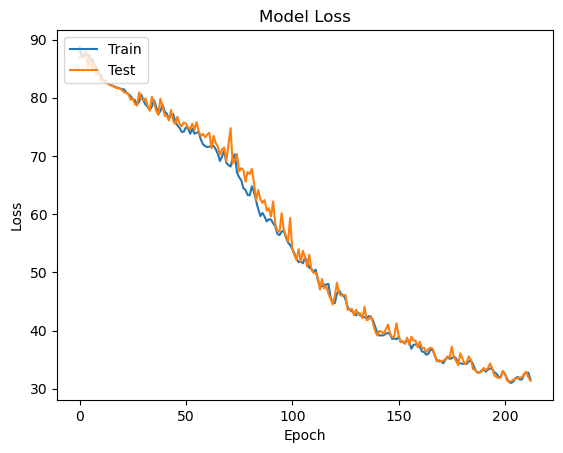

In [10]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(3453, 16, 1)
(3453, 16, 1)


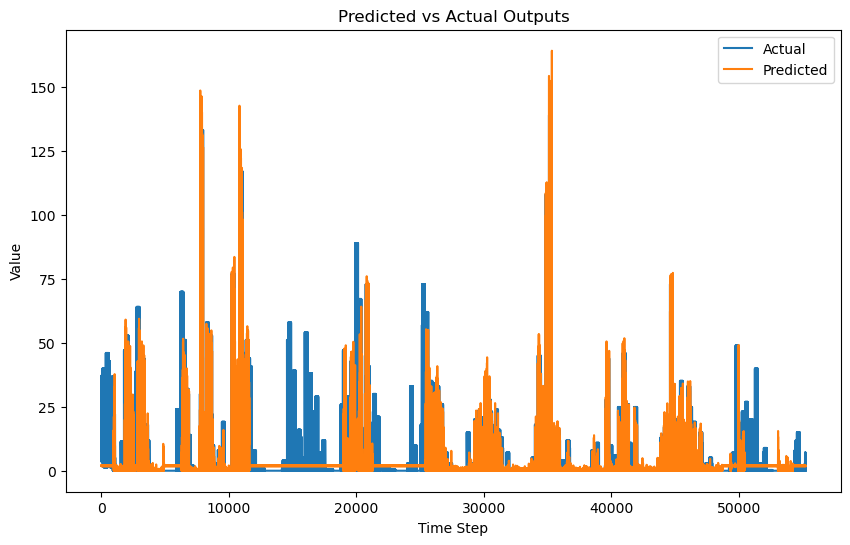

In [11]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
model.save_weights('corrector-ae.weights.h5')

In [13]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-daily-precipitation.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df['value'] = corrected_values[:len(beirut_df)]
beirut_df.to_csv('data/beirut-daily-corrected.csv', index=False)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
